In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

import os
from PIL import Image
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
KOOPMAN = True

In [17]:
@dataclass
class TrainingConfig:
    image_size = 32
    train_batch_size = 64
    eval_batch_size = 64
    num_epochs = 20
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 10
    output_dir = "ddpm_mnist_koopman" if KOOPMAN else "ddpm_mnist"
    seed = 0

config = TrainingConfig()
os.makedirs(config.output_dir, exist_ok=True)

In [18]:
def get_mnist_dataloader(image_size, batch_size):
    """Loads the MNIST dataset."""
    preprocess = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # (pixel - 0.5) / 0.5
        ]
    )

    dataset = torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=preprocess
    )

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [19]:
class KoopmanUNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        image_size = config.sample_size
        in_channels = config.in_channels
        out_channels = config.out_channels
        block_out_channels = config.block_out_channels
        layers_per_block = config.layers_per_block
        down_block_types = config.down_block_types
        up_block_types = config.up_block_types

        time_embed_dim = block_out_channels[0] * 4

        from diffusers.models.embeddings import Timesteps, TimestepEmbedding
        from diffusers.models.unets.unet_2d_blocks import (
            UNetMidBlock2D, get_down_block, get_up_block,
        )

        self.time_proj = Timesteps(block_out_channels[0], flip_sin_to_cos=True, downscale_freq_shift=0)
        self.time_embedding = TimestepEmbedding(
            in_channels=block_out_channels[0],
            time_embed_dim=time_embed_dim,
        )

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, padding=1)

        self.down_blocks = nn.ModuleList([])
        output_channel = block_out_channels[0]
        for i, down_block_type in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(down_block_types) - 1

            down_block = get_down_block(
                down_block_type,
                num_layers=layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=time_embed_dim,
                add_downsample=not is_final_block,
                resnet_eps=1e-5,
                resnet_act_fn="silu",
                resnet_groups=32,
                attention_head_dim=8,
                downsample_padding=1,
            )
            self.down_blocks.append(down_block)

        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            temb_channels=time_embed_dim,
            resnet_eps=1e-5,
            resnet_act_fn="silu",
            output_scale_factor=1,
            attention_head_dim=8,
            resnet_groups=32,
        )

        self.bottleneck_c = block_out_channels[-1]
        downsample_factor = 2 ** (len(down_block_types) - 1)
        self.bottleneck_h = image_size // downsample_factor
        self.bottleneck_w = image_size // downsample_factor
        self.bottleneck_features = self.bottleneck_c * self.bottleneck_h * self.bottleneck_w

        self.koopman_operator = nn.Linear(self.bottleneck_features, self.bottleneck_features)

        print(f"Koopman Bottleneck Initialized:")
        print(f"  Shape: ({self.bottleneck_c}, {self.bottleneck_h}, {self.bottleneck_w})")
        print(f"  Total Features: {self.bottleneck_features}")

        self.up_blocks = nn.ModuleList([])
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]
            input_channel = reversed_block_out_channels[min(i + 1, len(block_out_channels) - 1)]
            is_final_block = i == len(up_block_types) - 1

            up_block = get_up_block(
                up_block_type,
                num_layers=layers_per_block + 1,
                in_channels=input_channel,
                out_channels=output_channel,
                prev_output_channel=prev_output_channel,
                temb_channels=time_embed_dim,
                add_upsample=not is_final_block,
                resnet_eps=1e-5,
                resnet_act_fn="silu",
                resnet_groups=32,
                attention_head_dim=8,
            )
            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=32, eps=1e-5)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, kernel_size=3, padding=1)

    @property
    def dtype(self):
        """Return the dtype of the model parameters."""
        return next(self.parameters()).dtype

    @property
    def device(self):
        """Return the device of the model parameters."""
        return next(self.parameters()).device

    def forward(self, x, t, return_dict=False):
        batch_size = x.shape[0]
        device = x.device

        # time Embedding
        t = t.to(device)
        
        if t.dim() == 0:  # scalar tensor
            t = t.unsqueeze(0).expand(batch_size)
        elif t.dim() > 1:
            t = t.squeeze()
        
        # ensure t has the same batch size as x
        if t.shape[0] != batch_size:
            t = t.expand(batch_size)
        
        t_emb = self.time_proj(t)
        t_emb = self.time_embedding(t_emb)

        x = self.conv_in(x)

        # ENCODER
        skip_connections = (x,)
        for block in self.down_blocks:
            x, skips = block(x, t_emb)
            skip_connections += skips

        # MID BLOCK
        x = self.mid_block(x, t_emb)

        # 5. KOOPMAN BOTTLENECK
        x = x.reshape(batch_size, -1)
        x = self.koopman_operator(x)
        x = x.reshape(batch_size, self.bottleneck_c, self.bottleneck_h, self.bottleneck_w)

        # DECODER
        for block in self.up_blocks:
            num_skips = len(block.resnets)
            skips_for_this_block = skip_connections[-num_skips:]
            skip_connections = skip_connections[:-num_skips]
            x = block(x, skips_for_this_block, temb=t_emb)

        x = self.conv_norm_out(x)
        x = self.conv_act(x)
        x = self.conv_out(x)

        if return_dict:
            return {"sample": x}
        else:
            # Return an object with .sample attribute for pipeline compatibility
            from diffusers.utils import BaseOutput
            return BaseOutput(sample=x)

    def save_pretrained(self, path):
        torch.save(model.state_dict(), path + '/model.pth')

In [20]:
def setup_model_and_scheduler(image_size, koopman=False):
    """Initializes the U-Net model and noise scheduler."""
    baseline_model = UNet2DModel(
        sample_size=image_size,
        in_channels=1,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(32, 64, 128, 128),
        down_block_types=(
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
    )

    if koopman:
        model = KoopmanUNet(baseline_model.config)
    else:
        model = baseline_model

    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
    return model, noise_scheduler

In [21]:
def tensor_to_pil(image_tensor):
    """Converts a tensor image to a PIL Image."""
    image = (image_tensor / 2 + 0.5).clamp(0, 1) # Denormalize from [-1, 1] to [0, 1]
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(img.squeeze(), 'L') for img in images]
    return pil_images

def generate_and_save_images(model, scheduler, epoch, config):
    """Generates images and saves them to a file."""
    print(f"Generating images for epoch {epoch+1}...")
    model.eval()
    pipeline = DDPMPipeline(unet=model, scheduler=scheduler)

    # generate a batch of images
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    image_grid = torchvision.utils.make_grid(
        [transforms.ToTensor()(img) for img in images], nrow=8
    )

    pil_grid = transforms.ToPILImage()(image_grid)
    save_path = os.path.join(config.output_dir, f"epoch_{epoch+1:04d}.png")
    pil_grid.save(save_path)
    print(f"Saved image grid to {save_path}")

    display(pil_grid)

In [22]:
def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler, train_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"--- Starting Training on {device} ---")

    for epoch in range(config.num_epochs):
        model.train()  
        epoch_loss = 0.0

        for step, (images, _) in enumerate(tqdm(train_dataloader)):
            clean_images = images.to(device)
            batch_size = clean_images.shape[0]

            # sample random noise and timesteps
            noise = torch.randn_like(clean_images)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

            # add noise to the clean images (the "forward process")
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # get the model's prediction for the noise
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_dataloader)}")

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            generate_and_save_images(model, noise_scheduler, epoch, config)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            model_path = os.path.join(config.output_dir, "unet_model")
            os.makedirs(model_path, exist_ok=True)
            model.save_pretrained(model_path)
            print(f"Saved model to {model_path}")

Koopman Bottleneck Initialized:
  Shape: (128, 4, 4)
  Total Features: 2048
--- Starting Training on cuda ---


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 1 Average Loss: 0.14842664600927818


100%|██████████| 938/938 [01:05<00:00, 14.36it/s]


Epoch 2 Average Loss: 0.03002759870856619


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 3 Average Loss: 0.024880451653629287


100%|██████████| 938/938 [01:05<00:00, 14.36it/s]


Epoch 4 Average Loss: 0.022716660543021235


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]

Epoch 5 Average Loss: 0.021052639891725105
Generating images for epoch 5...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist_koopman/epoch_0005.png


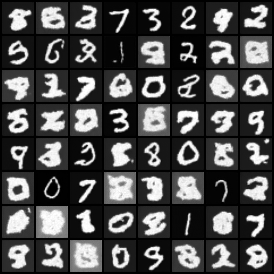

100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 6 Average Loss: 0.019833069753402204


100%|██████████| 938/938 [01:05<00:00, 14.35it/s]


Epoch 7 Average Loss: 0.01880961578232107


100%|██████████| 938/938 [01:05<00:00, 14.35it/s]


Epoch 8 Average Loss: 0.018105142700201922


100%|██████████| 938/938 [01:05<00:00, 14.36it/s]


Epoch 9 Average Loss: 0.01781699948036658


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]

Epoch 10 Average Loss: 0.01743182943546092
Generating images for epoch 10...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist_koopman/epoch_0010.png


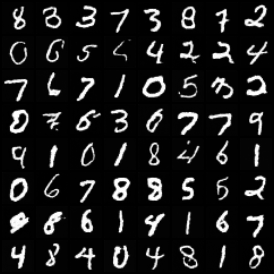

Saved model to ddpm_mnist_koopman/unet_model


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 11 Average Loss: 0.016987412958455555


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 12 Average Loss: 0.016636735264227778


100%|██████████| 938/938 [01:05<00:00, 14.37it/s]


Epoch 13 Average Loss: 0.016333763497565854


100%|██████████| 938/938 [01:05<00:00, 14.34it/s]


Epoch 14 Average Loss: 0.016296926815348712


100%|██████████| 938/938 [01:05<00:00, 14.32it/s]

Epoch 15 Average Loss: 0.016155066920805778
Generating images for epoch 15...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist_koopman/epoch_0015.png


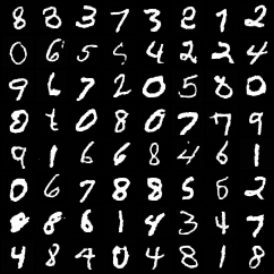

100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


Epoch 16 Average Loss: 0.015867303066980292


100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


Epoch 17 Average Loss: 0.015669266584573557


100%|██████████| 938/938 [01:05<00:00, 14.35it/s]


Epoch 18 Average Loss: 0.015526868056442374


100%|██████████| 938/938 [01:05<00:00, 14.36it/s]


Epoch 19 Average Loss: 0.01562333591421371


100%|██████████| 938/938 [01:05<00:00, 14.36it/s]

Epoch 20 Average Loss: 0.0156397928050888
Generating images for epoch 20...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist_koopman/epoch_0020.png


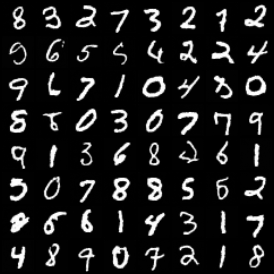

Saved model to ddpm_mnist_koopman/unet_model


In [23]:
train_dataloader = get_mnist_dataloader(config.image_size, config.train_batch_size)

model, noise_scheduler = setup_model_and_scheduler(config.image_size, koopman=KOOPMAN)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

train_loop(config, model, noise_scheduler, optimizer, lr_scheduler, train_dataloader)

Found 2048 Koopman modes.


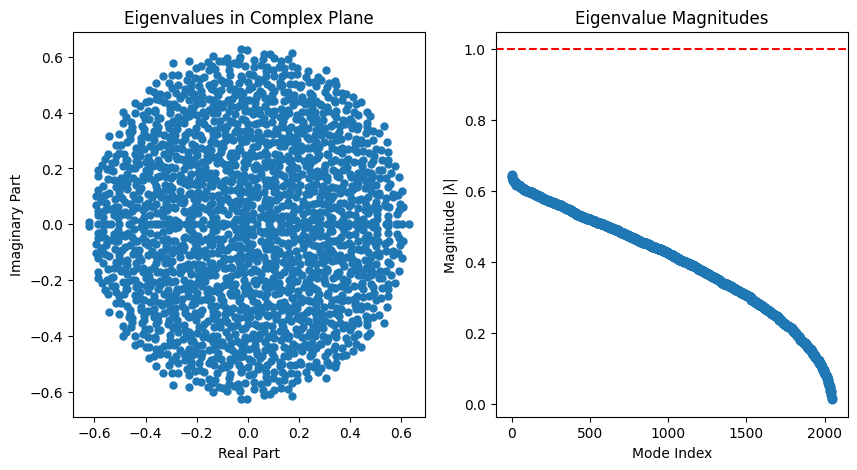

RuntimeError: Expected number of channels in input to be divisible by num_groups, but got input of shape [1, 1, 32, 32] and num_groups=32

<Figure size 1500x300 with 0 Axes>

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import warnings

# --- Set a nice plotting style ---
sns.set_theme(style="whitegrid", context="talk")

# --- Helper Function 1: Get Latent Vectors (Koopman) ---
@torch.no_grad()
def get_koopman_latents(model, dataloader, config, num_samples=1000):
    """
    Runs data through the KoopmanUNet ENCODER to get the
    bottleneck (latent) representations.
    """
    model.eval()
    device = next(model.parameters()).device
    latents = []
    labels = []
    
    # Create a single, reusable time embedding (e.g., t=500)
    t = torch.tensor([500], device=device).long()
    t_emb = model.time_proj(t)
    t_emb = model.time_embedding(t_emb)

    for x, y in dataloader:
        x = x.to(device)
        batch_size = x.shape[0]
        
        # Manually run the encoder path
        x = model.conv_in(x)
        for block in model.down_blocks:
            x, _ = block(x, t_emb) # We don't care about skips here
        x = model.mid_block(x, t_emb)
        
        # Get the latent vector (at the bottleneck)
        latent_vec = x.reshape(batch_size, -1)
        
        latents.append(latent_vec.cpu().numpy())
        labels.append(y.cpu().numpy())
        
        if len(latents) * config.train_batch_size >= num_samples:
            break
            
    return np.concatenate(latents), np.concatenate(labels)

# --- Helper Function 2: Get Latent Vectors (Baseline) ---
@torch.no_grad()
def get_baseline_latents(model, dataloader, config, num_samples=1000):
    """
    Runs data through the Baseline UNet ENCODER to get the
    bottleneck (latent) representations.
    """
    model.eval()
    device = next(model.parameters()).device
    latents = []
    labels = []
    
    t = torch.tensor([500], device=device).long()
    
    for x, y in dataloader:
        x = x.to(device)
        batch_size = x.shape[0]

        # Manually run the encoder path for a *standard* UNet
        # This is a bit more complex as we need to find the time_embed
        t_emb = model.time_proj(t)
        t_emb = model.time_embedding(t_emb, t_emb.dtype) # Diffusers 1.0 needs dtype
        x = model.conv_in(x)
        for block in model.down_blocks:
            x, _ = block(x, t_emb)
        x = model.mid_block(x, t_emb)
        
        latent_vec = x.reshape(batch_size, -1)
        
        latents.append(latent_vec.cpu().numpy())
        labels.append(y.cpu().numpy())
        
        if len(latents) * config.train_batch_size >= num_samples:
            break
            
    return np.concatenate(latents), np.concatenate(labels)


# --- The Main Visualization Function ---
@torch.no_grad()
def visualize_koopman_analysis(koopman_model, config, baseline_model=None, dataloader=None):
    """
    Generates and saves a full suite of visualizations
    for the trained KoopmanUNet.
    """
    print("--- Starting Koopman Analysis ---")
    
    # Ensure model is on the correct device and in eval mode
    koopman_model.eval()
    device = next(koopman_model.parameters()).device
    
    # --- 1. Get the Koopman Operator ---
    try:
        K = koopman_model.koopman_operator.weight.detach().cpu().numpy()
    except Exception as e:
        print(f"Error: Could not get 'koopman_operator' from model. {e}")
        return

    # --- Vis 1: Singular Values of K (The "Rank") ---
    print("Analyzing Koopman matrix K...")
    plt.figure(figsize=(10, 6))
    U, S, Vh = np.linalg.svd(K)
    plt.plot(S, 'o-')
    plt.title("Singular Value Spectrum of Koopman Matrix $K$", fontsize=16)
    plt.xlabel("Singular Value Index", fontsize=12)
    plt.ylabel("Singular Value", fontsize=12)
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("koopman_singular_values.png")
    plt.show()
    print("Saved 'koopman_singular_values.png'")

    # --- Vis 2: Eigenvalues of K (The "Dynamics") ---
    print("Analyzing eigenvalues...")
    eigenvalues, eigenvectors = np.linalg.eig(K)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: Eigenvalues in the complex plane
    circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', label="Unit Circle")
    ax1.add_patch(circle)
    ax1.scatter(np.real(eigenvalues), np.imag(eigenvalues), alpha=0.3, s=20)
    ax1.set_xlabel("Real Part")
    ax1.set_ylabel("Imaginary Part")
    ax1.set_title("Eigenvalues $\lambda$ in Complex Plane", fontsize=16)
    ax1.set_aspect('equal')
    ax1.legend()

    # Plot 2: Sorted eigenvalue magnitudes
    sorted_mags = np.sort(np.abs(eigenvalues))[::-1]
    ax2.plot(sorted_mags, 'o-')
    ax2.set_xlabel("Eigenvalue Index (Sorted)")
    ax2.set_ylabel("Magnitude $|\lambda|$")
    ax2.set_title("Sorted Eigenvalue Magnitudes", fontsize=16)
    ax2.set_yscale('log')
    
    fig.suptitle("Koopman Dynamics Analysis", fontsize=20, y=1.03)
    plt.tight_layout()
    plt.savefig("koopman_eigenvalues.png")
    plt.show()
    print("Saved 'koopman_eigenvalues.png'")

    # --- Vis 3: Koopman Modes (The "Patterns") ---
    print("Visualizing Koopman Modes (this is complex!)...")
    
    # We must generate "dummy" skip connection shapes
    t = torch.tensor([500], device=device).long()
    t_emb = koopman_model.time_proj(t)
    t_emb = koopman_model.time_embedding(t_emb)
    
    dummy_skips = []
    x = torch.zeros(1, 1, config.image_size, config.image_size).to(device)
    x = koopman_model.conv_in(x)
    dummy_skips.append(x)
    for block in koopman_model.down_blocks:
        x, skips = block(x, t_emb)
        dummy_skips.extend(skips)

    num_modes = 8
    fig, axs = plt.subplots(1, num_modes, figsize=(num_modes * 3, 4))
    
    # Sort by magnitude
    sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
    
    for i in range(num_modes):
        mode_index = sorted_indices[i]
        vector = eigenvectors[:, mode_index]
        
        # Pass the eigenvector (as latent) through the DECODER
        x = torch.tensor(np.real(vector)).float().to(device)
        x = x.reshape(1, koopman_model.bottleneck_c, koopman_model.bottleneck_h, koopman_model.bottleneck_w)
        
        # Use a *copy* of the dummy skips
        skips_to_pop = [s.clone() for s in dummy_skips]
        
        for block in koopman_model.up_blocks:
            num_resnets = len(block.resnets)
            # Pop the correct number of skips
            skips_for_this_block = [skips_to_pop.pop() for _ in range(num_resnets)]
            x = block(x, tuple(skips_for_this_block), temb=t_emb)
            
        # Final output conv
        x = koopman_model.conv_norm_out(x)
        x = koopman_model.conv_act(x)
        x = koopman_model.conv_out(x)
        
        # Plot the resulting image
        img = (x.squeeze().detach().cpu().numpy() / 2 + 0.5).clip(0, 1)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Mode {i}\n$|\lambda|={np.abs(eigenvalues[mode_index]):.3f}$")
        axs[i].axis('off')

    fig.suptitle("Top Koopman Modes (The Model's 'Building Blocks')", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.savefig("koopman_modes.png")
    plt.show()
    print("Saved 'koopman_modes.png'")

    # --- Vis 4: t-SNE Latent Space Comparison ---
    if baseline_model is not None and dataloader is not None:
        print("Creating t-SNE plots (this may take a minute)...")
        # Suppress warnings from scikit-learn
        warnings.filterwarnings('ignore')
        
        # Get latents for Koopman model
        k_latents, k_labels = get_koopman_latents(koopman_model, dataloader, config)
        
        # Get latents for Baseline model
        baseline_model.to(device)
        b_latents, b_labels = get_baseline_latents(baseline_model, dataloader, config)
        
        # Use PCA to speed up t-SNE
        pca = PCA(n_components=50)
        k_latents_pca = pca.fit_transform(k_latents)
        b_latents_pca = pca.fit_transform(b_latents)
        
        # Run t-SNE
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        k_tsne = tsne.fit_transform(k_latents_pca)
        b_tsne = tsne.fit_transform(b_latents_pca)
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Koopman t-SNE
        sns.scatterplot(
            x=k_tsne[:, 0], y=k_tsne[:, 1],
            hue=k_labels,
            palette=sns.color_palette("tab10", 10),
            legend="full",
            alpha=0.7,
            ax=ax1
        )
        ax1.set_title("Koopman U-Net Latent Space", fontsize=16)
        
        # Baseline t-SNE
        sns.scatterplot(
            x=b_tsne[:, 0], y=b_tsne[:, 1],
            hue=b_labels,
            palette=sns.color_palette("tab10", 10),
            legend="full",
            alpha=0.7,
            ax=ax2
        )
        ax2.set_title("Baseline U-Net Latent Space", fontsize=16)
        
        fig.suptitle("t-SNE Comparison of Bottleneck Representations", fontsize=20, y=1.03)
        plt.tight_layout()
        plt.savefig("koopman_tsne_comparison.png")
        plt.show()
        print("Saved 'koopman_tsne_comparison.png'")
        warnings.filterwarnings('default') # Turn warnings back on
        
    print("--- Analysis Complete ---")